# CAM and Salience Visualization of model

Use this with the data folder to get visualization goodies

In [1]:
from vis.utils import utils
from keras import activations
from keras.models import load_model

model = load_model('epochs_200_datav2_densev2_try1_2018-09-13_23-16-16_weights.chkpt.hdf5')

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nathaniel/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Isolation of branch

Now we selectively isolate the model for stenosis

In [20]:
from keras.models import Model

sten_model = Model(inputs=[model.inputs[0]], output=[model.outputs[1]])
sten_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           main_input[0][0]                 
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


## Modify stenosis

In [21]:
# layer_idx = utils.find_layer_idx(sten_model, 'stenosis_output')

# # Swap softmax with linear
# sten_model.layers[layer_idx].activation = activations.linear
# sten_model = utils.apply_modifications(sten_model)

/Users/nathaniel/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/nathaniel/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(224, 224, 3)


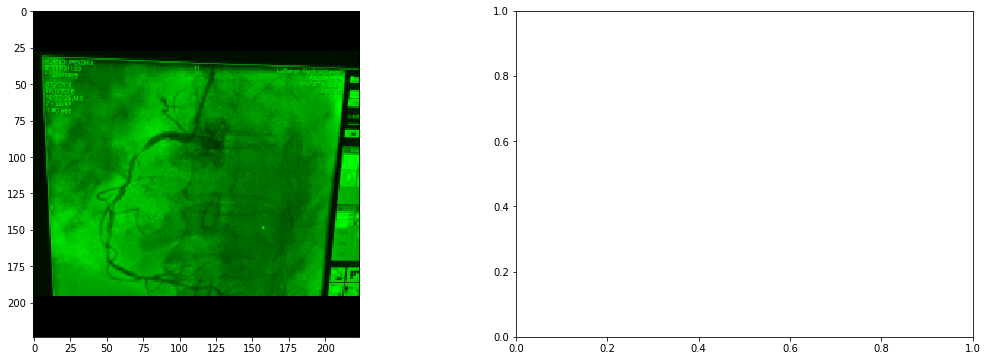

In [40]:
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img('../data/test/13_BK137-ptcanvas-sqtrim-resizeBW224.jpg', grayscale=False, target_size=(224, 224, 3))

f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
print(img1.shape)

<Figure size 1296x432 with 0 Axes>

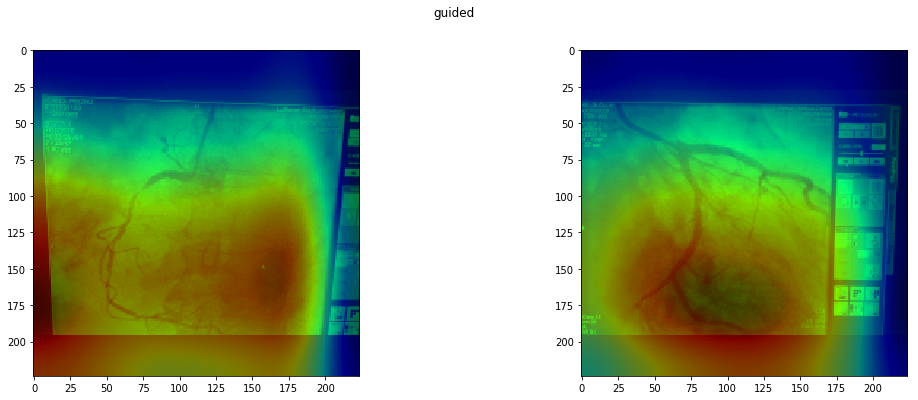

In [41]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

layer_idx = utils.find_layer_idx(sten_model, 'anatomy_output')
layer_pool = utils.find_layer_idx(sten_model, 'avg_pool_anatomy')

for modifier in ['guided']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle("vanilla" if modifier is None else modifier)
    for i, img in enumerate([img1, img2]):    
        grads = visualize_cam(sten_model, layer_pool, filter_indices=None, 
                              seed_input=img, backprop_modifier=modifier)        
        # Lets overlay the heatmap onto original image.    
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
        ax[i].imshow(overlay(jet_heatmap, img))

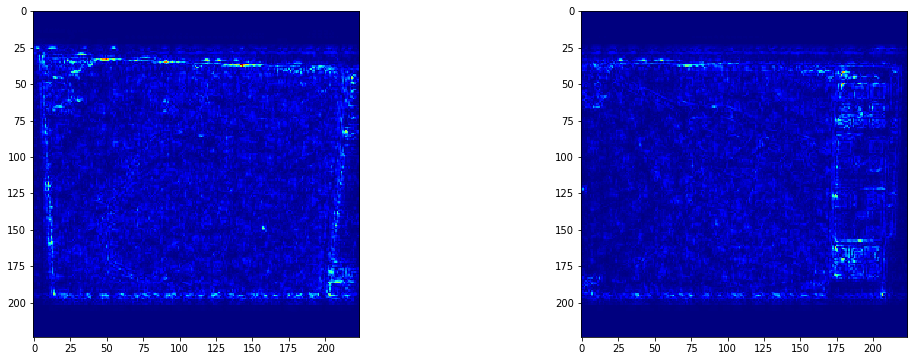

In [42]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations


f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(sten_model, layer_pool, filter_indices=None, seed_input=img, backprop_modifier='guided')
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')